#### Imports & Downloads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

from src.functions.vectorize_functions import vectorize_tfidf, vectorize_glove, vectorize_w2v

### Model Preparation

#### Functions

In [2]:
def print_target_distribution(df, colname):
    positive = np.count_nonzero(df[colname] == 1)
    negative = np.count_nonzero(df[colname] == 0)
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [3]:
evaluation = pd.DataFrame(
    columns=["model", "tuning", "vec_variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc",
             "test_prec",
             "test_rec", "test_f1"])

In [4]:
def add_to_eval_df(model, model_name, tuning, vec_variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, tuning, vec_variant, train_acc, train_precision, train_recall,
                                             train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [5]:
def evaluate_model(model, x_test, y_test):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### Data Import

In [6]:
df_train_cleaned = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\train_cleaned.csv")

In [7]:
print_target_distribution(df_train_cleaned, 'label')

- Positive: 1331
- Negative: 18848
- Verhältnis: 14.160781367392937


In [8]:
df_train_cleaned = df_train_cleaned[df_train_cleaned.tweet_cleaned.notna()]
df_train_cleaned.isna().sum()

id                   0
label                0
tweet                0
tweet_cleaned        0
user_handle          0
hashtags             0
emojis           15873
dtype: int64

#### Vectorize - Word2Vec

In [9]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = vectorize_w2v(df=df_train_cleaned,
                                                                 text_column="tweet_cleaned",
                                                                 label_column="label")

#### Vectorize - TF-IDF

In [10]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = vectorize_tfidf(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

#### Vectorize - Glove

In [11]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl = vectorize_glove(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

### Training Functions

In [12]:
def cross_validate_model(model, x_data, y_data, cv=10, scoring='f1'):
    cv = cross_val_score(model, x_data, y_data, cv=cv, scoring=scoring, verbose=10)
    print(f" MEAN: {np.mean(cv)}")

    return cv

#### 1.1 Bagging

##### 1.1.1 RandomForest

In [13]:
def train_randomforest(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [14]:
def train_randomforest_tuned_randsearch(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
    model.fit(x_data, y_data)

    return model

In [15]:
def train_randomforest_tuned_optuna(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, n_estimators=450, max_depth=55, min_samples_split=4, min_samples_leaf=1)
    model.fit(x_data, y_data)

    return model

##### 1.1.2 BalancedRandomForest untuned

In [16]:
def train_balancedrandomforest(x_data, y_data):
    model = BalancedRandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [17]:
# def train_balancedrandomforest_tuned(x_data, y_data):
#     model = BalancedRandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
#     model.fit(x_data, y_data)
#
#     return model

#### 1.2 Boosting

##### 1.2.1 XGBClassifier

In [18]:
def train_xgboost(x_data, y_data):
    model = XGBClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [19]:
def train_xgboost_tuned_gridsearch(x_data, y_data):
    model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
    model.fit(x_data, y_data)

    return model

In [20]:
def train_xgboost_tuned_randsearch(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, subsample=0.5, reg_alpha=1, n_estimators=150, min_child_weight=1,
                          max_depth=7, learning_rate=0.1, gamma=0.4)
    model.fit(x_data, y_data)

    return model

In [21]:
def train_xgboost_tuned_optuna(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, boost='gblinear', subsample=0.4736419905302216,
                          colsample_bytree=0.6711055768358083, alpha=8.528933855762793e-06)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 CatBoostClassifier

In [22]:
def train_catboost(x_data, y_data):
    model = CatBoostClassifier(iterations=100,
                               depth=5,
                               learning_rate=0.1,
                               loss_function='Logloss',
                               verbose=True)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 LGBMClassifier

In [23]:
def train_lightgbm(x_data, y_data):
    model = LGBMClassifier()
    model.fit(x_data, y_data)

    return model

#### 1.3 Stacking

##### 1.3.1 Stacking: RandomForest + LinearSVC

In [24]:
def train_stacking_rf_svm(x_data, y_data):
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', LinearSVC(random_state=42))
    ]
    model = StackingClassifier(estimators=base_models, n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [25]:
def train_svc(x_data, y_data):
    model = LinearSVC()
    model.fit(x_data, y_data)

    return model

### Model Training

#### W2V

model accuracy for classification is = 95.14%
------------------------------------------------
Confusion Matrix:
      0    1
0  5658   29
1   265  102
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.78      0.28      0.41       367

    accuracy                           0.95      6054
   macro avg       0.87      0.64      0.69      6054
weighted avg       0.94      0.95      0.94      6054



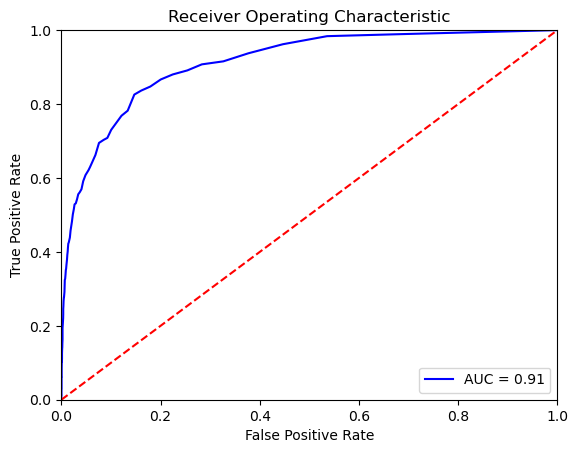

In [26]:
rf_untuned_w2v = train_randomforest(X_train_w2v, y_train_w2v)
evaluate_model(rf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_untuned_w2v, "RandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 94.81%
------------------------------------------------
Confusion Matrix:
      0   1
0  5657  30
1   284  83
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5687
           1       0.73      0.23      0.35       367

    accuracy                           0.95      6054
   macro avg       0.84      0.61      0.66      6054
weighted avg       0.94      0.95      0.93      6054



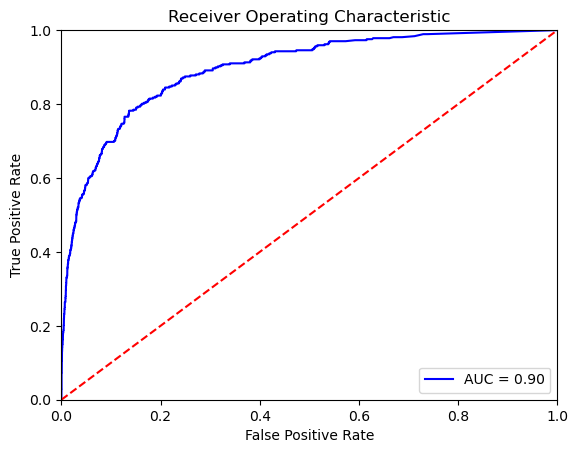

In [27]:
rf_rand_w2v = train_randomforest_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(rf_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_rand_w2v, "RandomForest", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 95.19%
------------------------------------------------
Confusion Matrix:
      0    1
0  5657   30
1   261  106
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.78      0.29      0.42       367

    accuracy                           0.95      6054
   macro avg       0.87      0.64      0.70      6054
weighted avg       0.95      0.95      0.94      6054



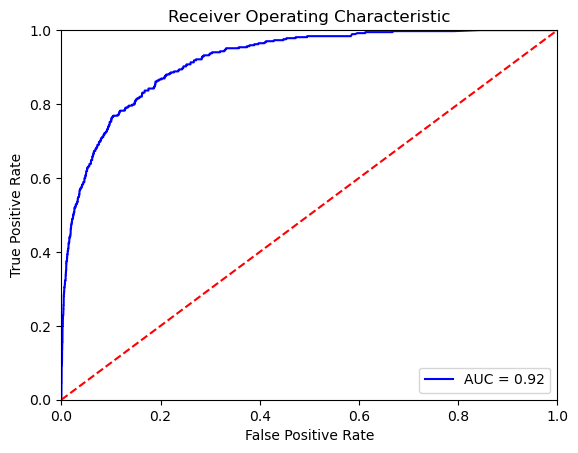

In [28]:
rf_optuna_w2v = train_randomforest_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(rf_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_optuna_w2v, "RandomForest", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 85.37%
------------------------------------------------
Confusion Matrix:
      0    1
0  4862  825
1    61  306
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      5687
           1       0.27      0.83      0.41       367

    accuracy                           0.85      6054
   macro avg       0.63      0.84      0.66      6054
weighted avg       0.94      0.85      0.89      6054



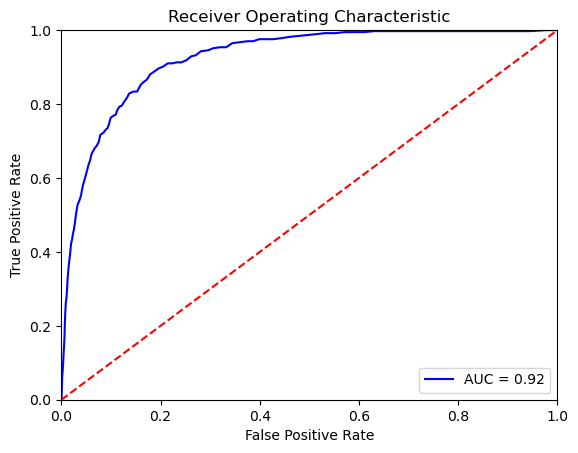

In [29]:
brf_untuned_w2v = train_balancedrandomforest(X_train_w2v, y_train_w2v)
evaluate_model(brf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(brf_untuned_w2v, "BalancedRandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

model accuracy for classification is = 95.16%
------------------------------------------------
Confusion Matrix:
      0    1
0  5620   67
1   226  141
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.68      0.38      0.49       367

    accuracy                           0.95      6054
   macro avg       0.82      0.69      0.73      6054
weighted avg       0.94      0.95      0.95      6054



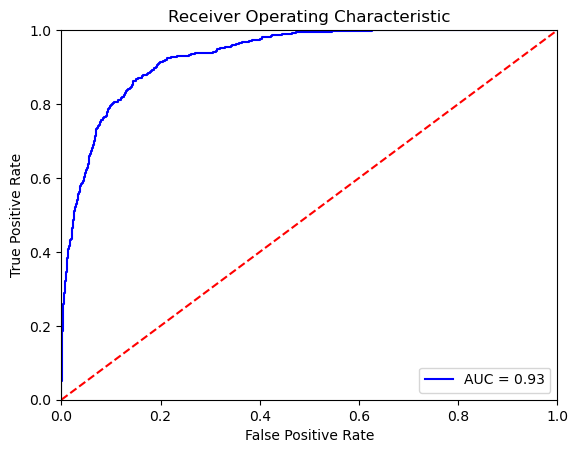

In [30]:
xgb_untuned_w2v = train_xgboost(X_train_w2v, y_train_w2v)
evaluate_model(xgb_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_untuned_w2v, "XGBoost", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 95.16%
------------------------------------------------
Confusion Matrix:
      0    1
0  5626   61
1   232  135
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.69      0.37      0.48       367

    accuracy                           0.95      6054
   macro avg       0.82      0.68      0.73      6054
weighted avg       0.94      0.95      0.94      6054



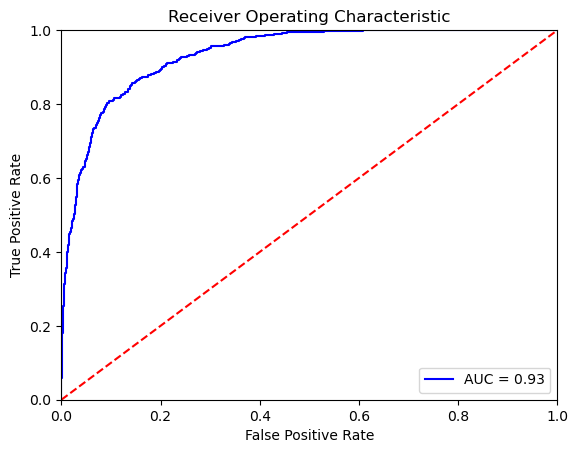

In [31]:
xgb_grid_w2v = train_xgboost_tuned_gridsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_grid_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_grid_w2v, "XGBoost", "gridsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 95.23%
------------------------------------------------
Confusion Matrix:
      0    1
0  5627   60
1   229  138
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.70      0.38      0.49       367

    accuracy                           0.95      6054
   macro avg       0.83      0.68      0.73      6054
weighted avg       0.94      0.95      0.95      6054



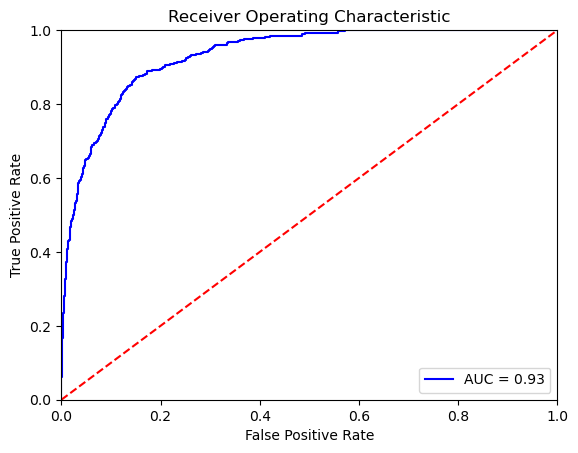

In [32]:
xgb_rand_w2v = train_xgboost_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_rand_w2v, "XGBoost", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:43] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 94.96%
------------------------------------------------
Confusion Matrix:
      0    1
0  5602   85
1   220  147
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.63      0.40      0.49       367

    accuracy                           0.95      6054
   macro avg       0.80      0.69      0.73      6054
weighted avg       0.94      0.95      0.94      6054



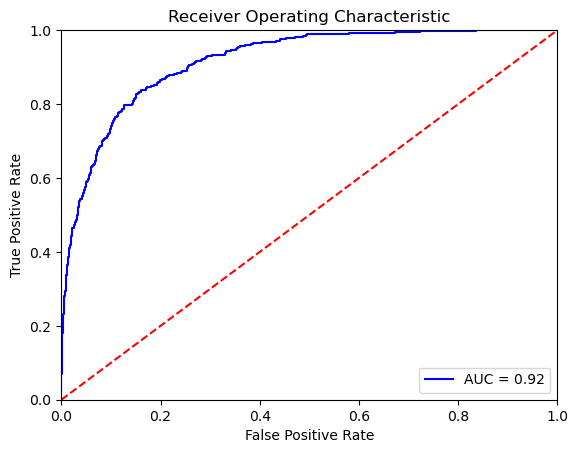

In [33]:
xgb_optuna_w2v = train_xgboost_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(xgb_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_optuna_w2v, "XGBoost", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

0:	learn: 0.5547841	total: 177ms	remaining: 17.5s
1:	learn: 0.4483402	total: 199ms	remaining: 9.76s
2:	learn: 0.3714084	total: 220ms	remaining: 7.12s
3:	learn: 0.3175345	total: 242ms	remaining: 5.81s
4:	learn: 0.2806616	total: 264ms	remaining: 5.02s
5:	learn: 0.2531924	total: 287ms	remaining: 4.49s
6:	learn: 0.2351077	total: 308ms	remaining: 4.09s
7:	learn: 0.2219626	total: 329ms	remaining: 3.79s
8:	learn: 0.2094989	total: 350ms	remaining: 3.54s
9:	learn: 0.2000093	total: 403ms	remaining: 3.63s
10:	learn: 0.1914363	total: 427ms	remaining: 3.46s
11:	learn: 0.1851385	total: 453ms	remaining: 3.32s
12:	learn: 0.1806476	total: 477ms	remaining: 3.19s
13:	learn: 0.1766656	total: 503ms	remaining: 3.09s
14:	learn: 0.1730069	total: 530ms	remaining: 3s
15:	learn: 0.1692177	total: 553ms	remaining: 2.9s
16:	learn: 0.1661691	total: 577ms	remaining: 2.82s
17:	learn: 0.1633445	total: 603ms	remaining: 2.75s
18:	learn: 0.1610301	total: 628ms	remaining: 2.68s
19:	learn: 0.1595509	total: 650ms	remaining: 

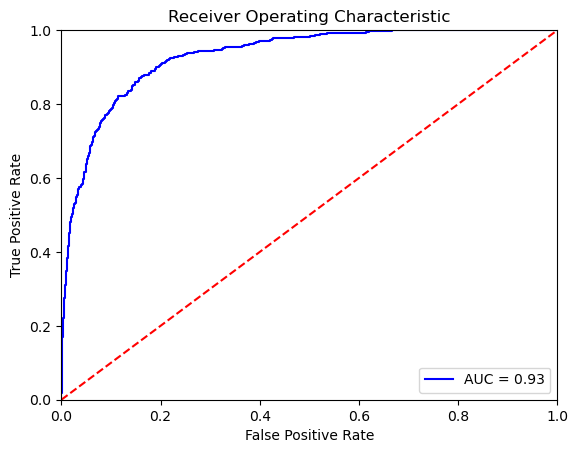

In [34]:
cat_untuned_w2v = train_catboost(X_train_w2v, y_train_w2v)
evaluate_model(cat_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(cat_untuned_w2v, "CatBoostClassifier", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

[LightGBM] [Info] Number of positive: 964, number of negative: 13160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 14124, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068253 -> initscore=-2.613846
[LightGBM] [Info] Start training from score -2.613846
model accuracy for classification is = 95.01%
------------------------------------------------
Confusion Matrix:
      0    1
0  5611   76
1   226  141
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.65      0.38      0.48       367

    accuracy                           0.95      6054
   macro avg       0.81      0.69      0.73      6054
weighted a

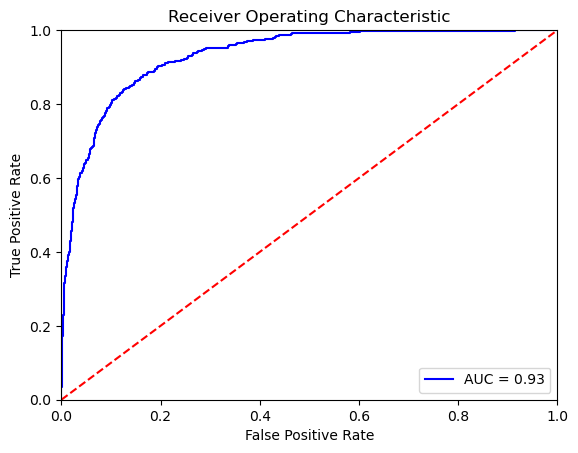

In [35]:
light_untuned_w2v = train_lightgbm(X_train_w2v, y_train_w2v)
evaluate_model(light_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(light_untuned_w2v, "LightGBM", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 95.18%
------------------------------------------------
Confusion Matrix:
      0    1
0  5626   61
1   231  136
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.69      0.37      0.48       367

    accuracy                           0.95      6054
   macro avg       0.83      0.68      0.73      6054
weighted avg       0.94      0.95      0.94      6054



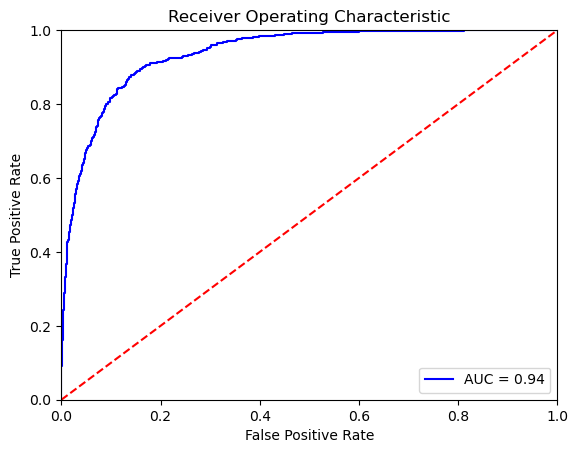

In [36]:
stack_untuned_w2v = train_stacking_rf_svm(X_train_w2v, y_train_w2v)
evaluate_model(stack_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(stack_untuned_w2v, "StackingClassifier-RF-SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

In [37]:
svc_untuned_w2v = train_svc(X_train_w2v, y_train_w2v)
add_to_eval_df(svc_untuned_w2v, "SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### TF-IDF

model accuracy for classification is = 95.97%
------------------------------------------------
Confusion Matrix:
      0    1
0  5662   25
1   219  148
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5687
           1       0.86      0.40      0.55       367

    accuracy                           0.96      6054
   macro avg       0.91      0.70      0.76      6054
weighted avg       0.96      0.96      0.95      6054



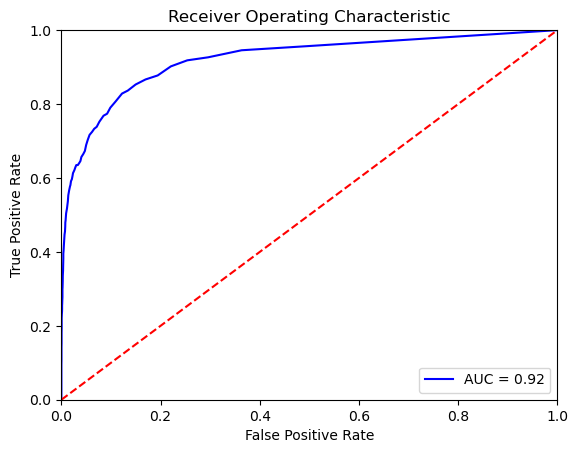

In [38]:
rf_untuned_tf = train_randomforest(X_train_tf, y_train_tf)
evaluate_model(rf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_untuned_tf, "RandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.09%
------------------------------------------------
Confusion Matrix:
      0    1
0  5653   34
1   263  104
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.75      0.28      0.41       367

    accuracy                           0.95      6054
   macro avg       0.85      0.64      0.69      6054
weighted avg       0.94      0.95      0.94      6054



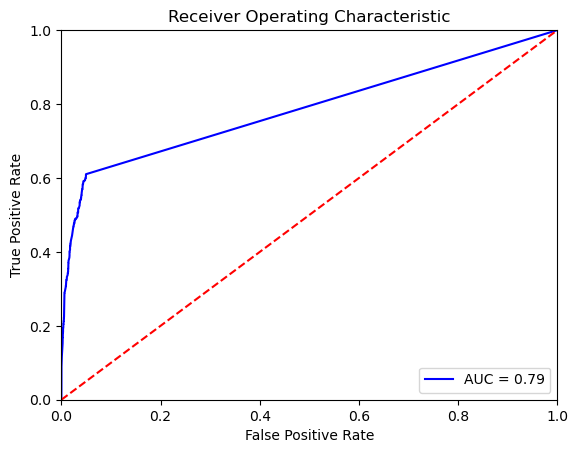

In [39]:
rf_rand_tf = train_randomforest_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(rf_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_rand_tf, "RandomForest", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.75%
------------------------------------------------
Confusion Matrix:
      0   1
0  5687   0
1   318  49
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5687
           1       1.00      0.13      0.24       367

    accuracy                           0.95      6054
   macro avg       0.97      0.57      0.60      6054
weighted avg       0.95      0.95      0.93      6054



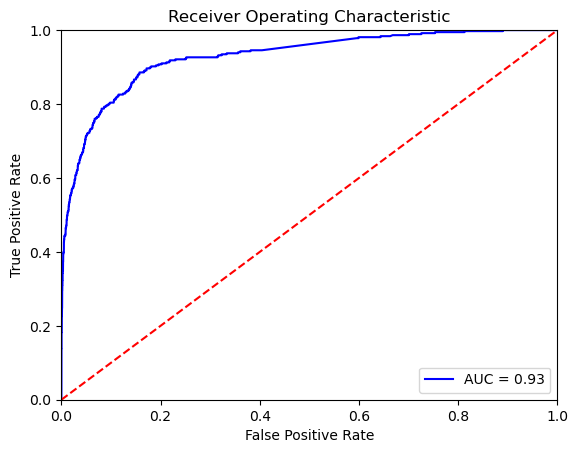

In [40]:
rf_optuna_tf = train_randomforest_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(rf_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_optuna_tf, "RandomForest", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 84.21%
------------------------------------------------
Confusion Matrix:
      0    1
0  4790  897
1    59  308
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      5687
           1       0.26      0.84      0.39       367

    accuracy                           0.84      6054
   macro avg       0.62      0.84      0.65      6054
weighted avg       0.94      0.84      0.88      6054



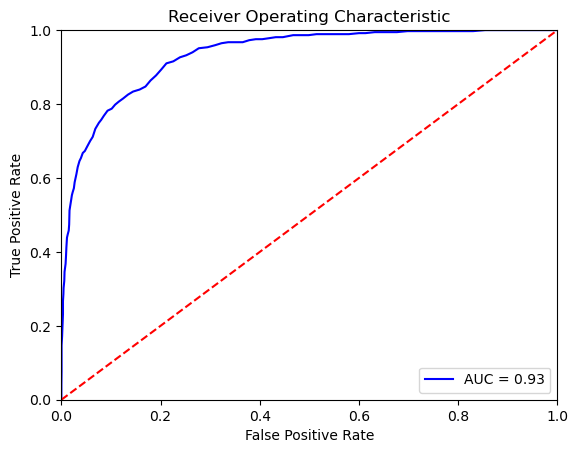

In [41]:
brf_untuned_tf = train_balancedrandomforest(X_train_tf, y_train_tf)
evaluate_model(brf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(brf_untuned_tf, "BalancedRandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.67%
------------------------------------------------
Confusion Matrix:
      0    1
0  5651   36
1   226  141
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.80      0.38      0.52       367

    accuracy                           0.96      6054
   macro avg       0.88      0.69      0.75      6054
weighted avg       0.95      0.96      0.95      6054



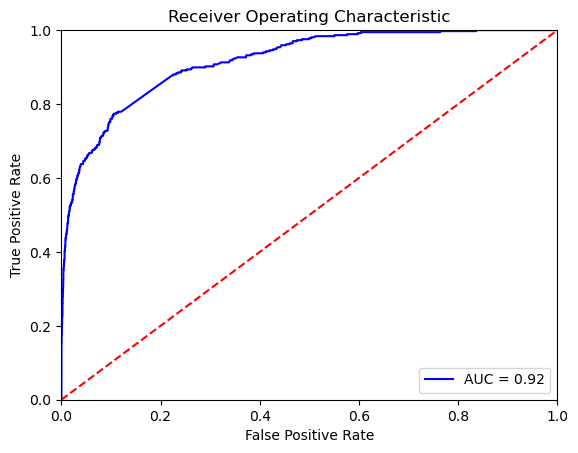

In [42]:
xgb_untuned_tf = train_xgboost(X_train_tf, y_train_tf)
evaluate_model(xgb_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_untuned_tf, "XGBoost", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.62%
------------------------------------------------
Confusion Matrix:
      0    1
0  5639   48
1   217  150
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.76      0.41      0.53       367

    accuracy                           0.96      6054
   macro avg       0.86      0.70      0.75      6054
weighted avg       0.95      0.96      0.95      6054



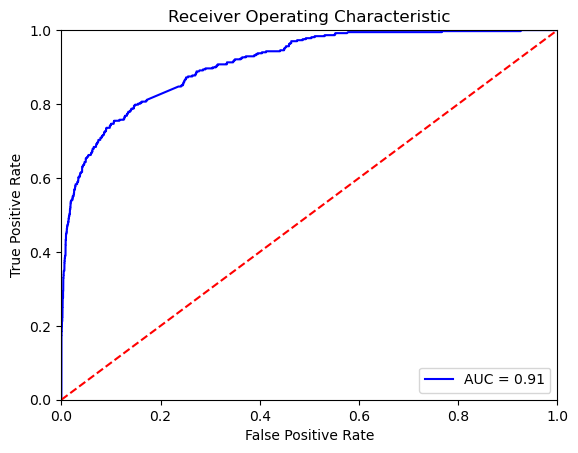

In [43]:
xgb_grid_tf = train_xgboost_tuned_gridsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_grid_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_grid_tf, "XGBoost", "gridsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.33%
------------------------------------------------
Confusion Matrix:
      0    1
0  5642   45
1   238  129
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.74      0.35      0.48       367

    accuracy                           0.95      6054
   macro avg       0.85      0.67      0.73      6054
weighted avg       0.95      0.95      0.95      6054



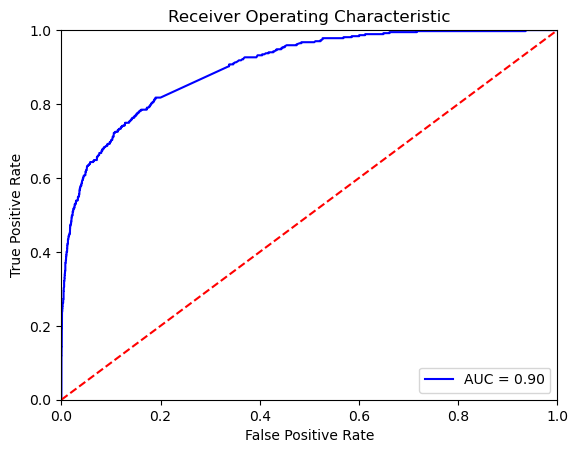

In [44]:
xgb_rand_tf = train_xgboost_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_rand_tf, "XGBoost", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:46] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 95.42%
------------------------------------------------
Confusion Matrix:
      0    1
0  5633   54
1   223  144
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.73      0.39      0.51       367

    accuracy                           0.95      6054
   macro avg       0.84      0.69      0.74      6054
weighted avg       0.95      0.95      0.95      6054



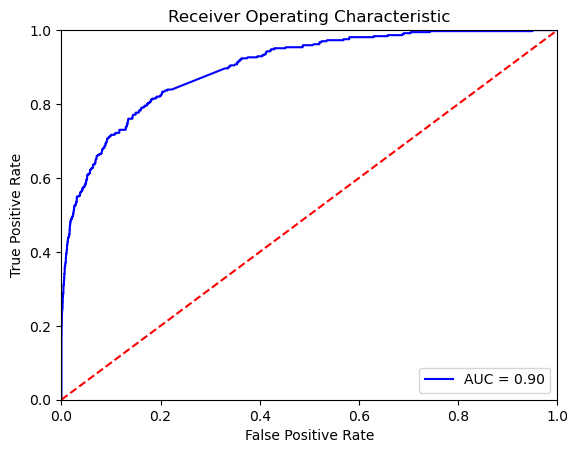

In [45]:
xgb_optuna_tf = train_xgboost_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(xgb_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_optuna_tf, "XGBoost", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

0:	learn: 0.5878504	total: 64.9ms	remaining: 6.42s
1:	learn: 0.5083806	total: 127ms	remaining: 6.21s
2:	learn: 0.4472012	total: 180ms	remaining: 5.82s
3:	learn: 0.3980520	total: 233ms	remaining: 5.6s
4:	learn: 0.3589142	total: 294ms	remaining: 5.59s
5:	learn: 0.3289160	total: 357ms	remaining: 5.59s
6:	learn: 0.3033367	total: 417ms	remaining: 5.54s
7:	learn: 0.2818252	total: 476ms	remaining: 5.47s
8:	learn: 0.2685399	total: 540ms	remaining: 5.46s
9:	learn: 0.2572590	total: 600ms	remaining: 5.4s
10:	learn: 0.2478268	total: 661ms	remaining: 5.35s
11:	learn: 0.2397083	total: 722ms	remaining: 5.29s
12:	learn: 0.2329392	total: 776ms	remaining: 5.19s
13:	learn: 0.2277790	total: 846ms	remaining: 5.19s
14:	learn: 0.2235385	total: 900ms	remaining: 5.1s
15:	learn: 0.2198037	total: 955ms	remaining: 5.01s
16:	learn: 0.2165632	total: 1.01s	remaining: 4.93s
17:	learn: 0.2138707	total: 1.06s	remaining: 4.86s
18:	learn: 0.2117195	total: 1.12s	remaining: 4.77s
19:	learn: 0.2096245	total: 1.18s	remaining

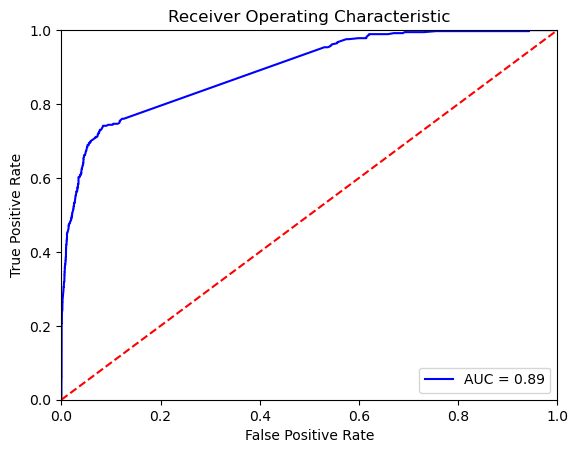

In [46]:
cat_untuned_tf = train_catboost(X_train_tf, y_train_tf)
evaluate_model(cat_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(cat_untuned_tf, "CatBoostClassifier", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

[LightGBM] [Info] Number of positive: 964, number of negative: 13160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28759
[LightGBM] [Info] Number of data points in the train set: 14124, number of used features: 1080
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068253 -> initscore=-2.613846
[LightGBM] [Info] Start training from score -2.613846
model accuracy for classification is = 95.44%
------------------------------------------------
Confusion Matrix:
      0    1
0  5632   55
1   221  146
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.73      0.40      0.51       367

    accuracy                           0.95      6054

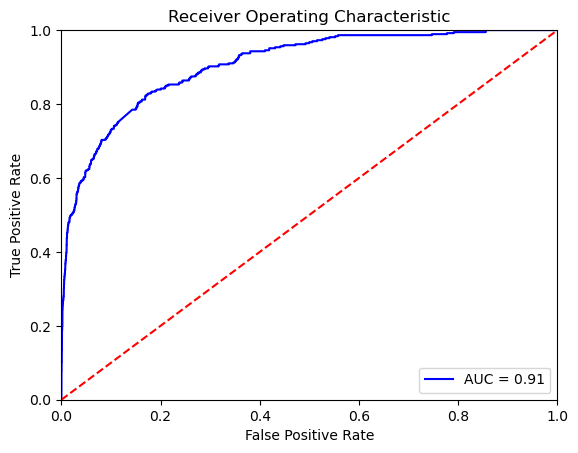

In [47]:
light_untuned_tf = train_lightgbm(X_train_tf, y_train_tf)
evaluate_model(light_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(light_untuned_tf, "LightGBM", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 96.05%
------------------------------------------------
Confusion Matrix:
      0    1
0  5604   83
1   156  211
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5687
           1       0.72      0.57      0.64       367

    accuracy                           0.96      6054
   macro avg       0.85      0.78      0.81      6054
weighted avg       0.96      0.96      0.96      6054



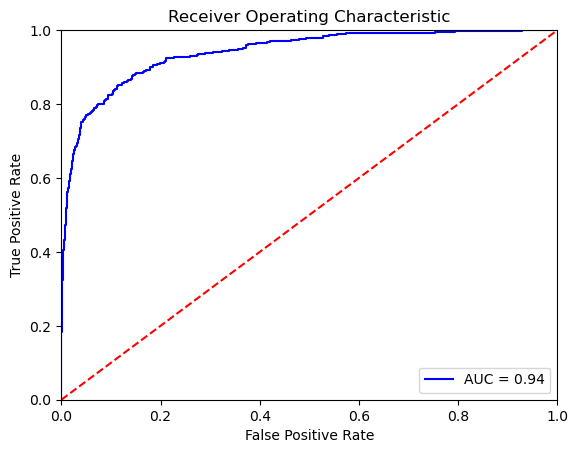

In [48]:
stack_untuned_tf = train_stacking_rf_svm(X_train_tf, y_train_tf)
evaluate_model(stack_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(stack_untuned_tf, "StackingClassifier-RF-SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf,
               y_test_tf)

In [49]:
svc_untuned_tf = train_svc(X_train_tf, y_train_tf)
add_to_eval_df(svc_untuned_tf, "SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

#### Glove100d

model accuracy for classification is = 94.76%
------------------------------------------------
Confusion Matrix:
      0   1
0  5678   9
1   308  59
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5687
           1       0.87      0.16      0.27       367

    accuracy                           0.95      6054
   macro avg       0.91      0.58      0.62      6054
weighted avg       0.94      0.95      0.93      6054



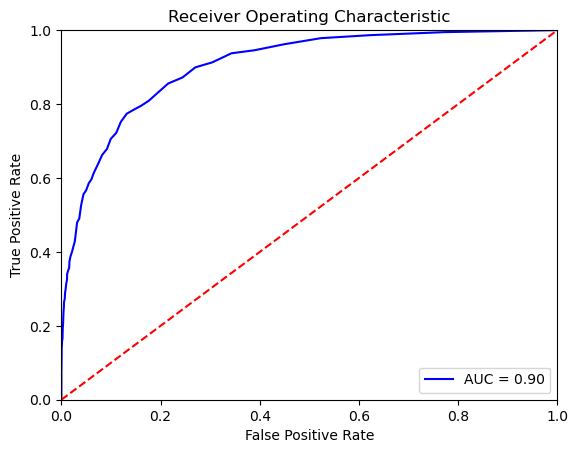

In [50]:
rf_untuned_gl = train_randomforest(X_train_gl, y_train_gl)
evaluate_model(rf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_untuned_gl, "RandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.50%
------------------------------------------------
Confusion Matrix:
      0   1
0  5676  11
1   322  45
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5687
           1       0.80      0.12      0.21       367

    accuracy                           0.94      6054
   macro avg       0.87      0.56      0.59      6054
weighted avg       0.94      0.94      0.93      6054



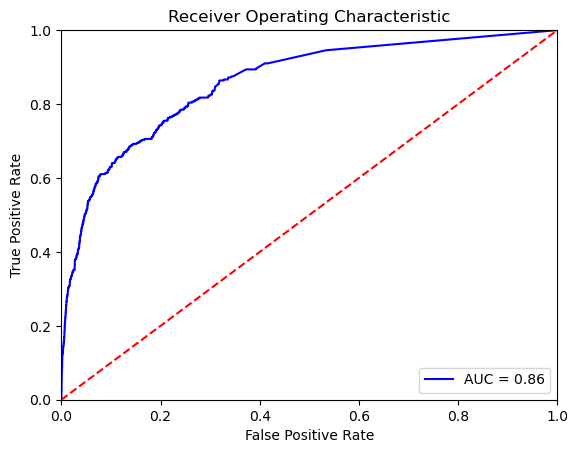

In [51]:
rf_rand_gl = train_randomforest_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(rf_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_rand_gl, "RandomForest", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.65%
------------------------------------------------
Confusion Matrix:
      0   1
0  5676  11
1   313  54
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5687
           1       0.83      0.15      0.25       367

    accuracy                           0.95      6054
   macro avg       0.89      0.57      0.61      6054
weighted avg       0.94      0.95      0.93      6054



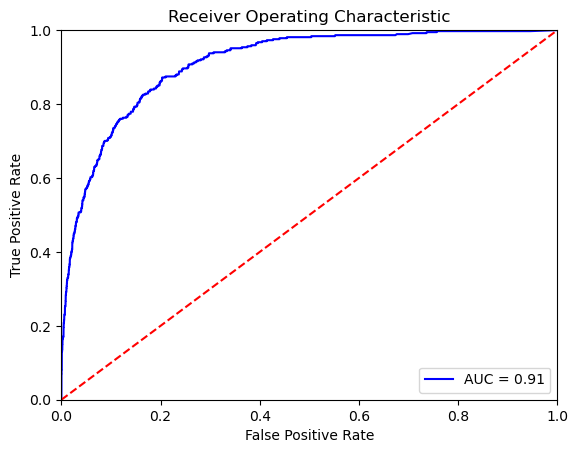

In [52]:
rf_optuna_gl = train_randomforest_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(rf_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_optuna_gl, "RandomForest", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 84.84%
------------------------------------------------
Confusion Matrix:
      0    1
0  4821  866
1    52  315
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      5687
           1       0.27      0.86      0.41       367

    accuracy                           0.85      6054
   macro avg       0.63      0.85      0.66      6054
weighted avg       0.95      0.85      0.88      6054



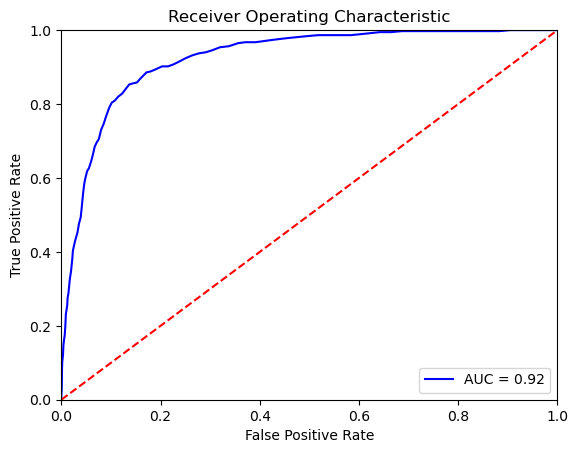

In [53]:
brf_untuned_gl = train_balancedrandomforest(X_train_gl, y_train_gl)
evaluate_model(brf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(brf_untuned_gl, "BalancedRandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 95.31%
------------------------------------------------
Confusion Matrix:
      0    1
0  5624   63
1   221  146
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.70      0.40      0.51       367

    accuracy                           0.95      6054
   macro avg       0.83      0.69      0.74      6054
weighted avg       0.95      0.95      0.95      6054



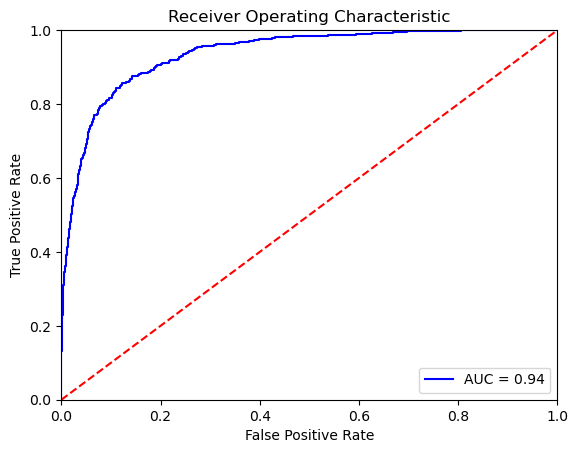

In [54]:
xgb_untuned_gl = train_xgboost(X_train_gl, y_train_gl)
evaluate_model(xgb_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_untuned_gl, "XGBoost", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 95.52%
------------------------------------------------
Confusion Matrix:
      0    1
0  5644   43
1   228  139
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.76      0.38      0.51       367

    accuracy                           0.96      6054
   macro avg       0.86      0.69      0.74      6054
weighted avg       0.95      0.96      0.95      6054



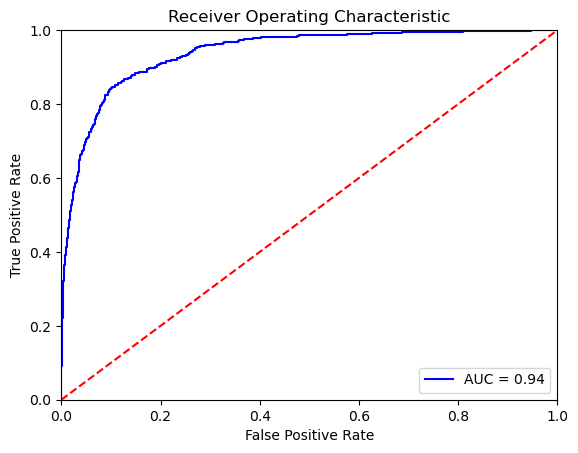

In [55]:
xgb_grid_gl = train_xgboost_tuned_gridsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_grid_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_grid_gl, "XGBoost", "gridsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 95.34%
------------------------------------------------
Confusion Matrix:
      0    1
0  5631   56
1   226  141
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.72      0.38      0.50       367

    accuracy                           0.95      6054
   macro avg       0.84      0.69      0.74      6054
weighted avg       0.95      0.95      0.95      6054



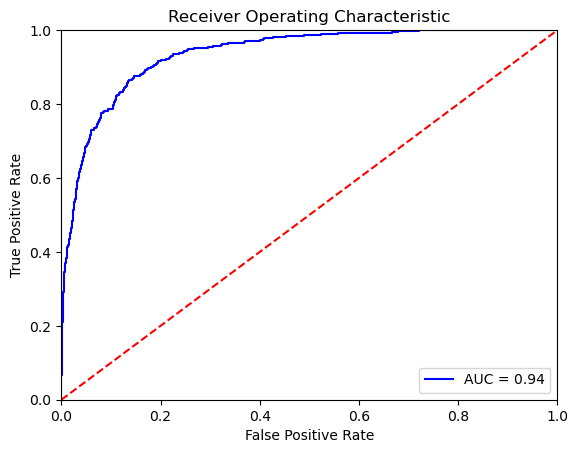

In [56]:
xgb_rand_gl = train_xgboost_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_rand_gl, "XGBoost", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:50] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 94.98%
------------------------------------------------
Confusion Matrix:
      0    1
0  5603   84
1   220  147
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.64      0.40      0.49       367

    accuracy                           0.95      6054
   macro avg       0.80      0.69      0.73      6054
weighted avg       0.94      0.95      0.94      6054



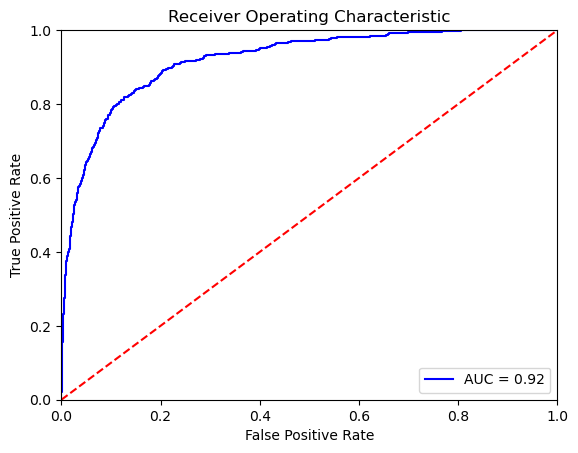

In [57]:
xgb_optuna_gl = train_xgboost_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(xgb_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_optuna_gl, "XGBoost", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

0:	learn: 0.5726330	total: 26.2ms	remaining: 2.59s
1:	learn: 0.4874938	total: 40.4ms	remaining: 1.98s
2:	learn: 0.4102307	total: 52.6ms	remaining: 1.7s
3:	learn: 0.3600151	total: 67ms	remaining: 1.61s
4:	learn: 0.3196812	total: 81.7ms	remaining: 1.55s
5:	learn: 0.2906514	total: 95.5ms	remaining: 1.5s
6:	learn: 0.2666631	total: 109ms	remaining: 1.45s
7:	learn: 0.2459049	total: 122ms	remaining: 1.41s
8:	learn: 0.2285693	total: 135ms	remaining: 1.36s
9:	learn: 0.2174225	total: 149ms	remaining: 1.34s
10:	learn: 0.2102428	total: 163ms	remaining: 1.32s
11:	learn: 0.2013885	total: 178ms	remaining: 1.31s
12:	learn: 0.1961528	total: 192ms	remaining: 1.28s
13:	learn: 0.1917792	total: 205ms	remaining: 1.26s
14:	learn: 0.1871552	total: 217ms	remaining: 1.23s
15:	learn: 0.1822172	total: 232ms	remaining: 1.22s
16:	learn: 0.1780034	total: 247ms	remaining: 1.21s
17:	learn: 0.1756639	total: 262ms	remaining: 1.2s
18:	learn: 0.1727851	total: 278ms	remaining: 1.18s
19:	learn: 0.1709630	total: 292ms	remain

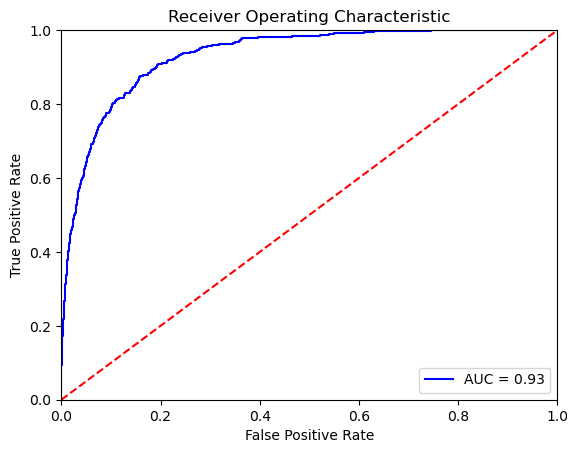

In [58]:
cat_untuned_gl = train_catboost(X_train_gl, y_train_gl)
evaluate_model(cat_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(cat_untuned_gl, "CatBoostClassifier", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

[LightGBM] [Info] Number of positive: 964, number of negative: 13160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 14124, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068253 -> initscore=-2.613846
[LightGBM] [Info] Start training from score -2.613846
model accuracy for classification is = 95.39%
------------------------------------------------
Confusion Matrix:
      0    1
0  5634   53
1   226  141
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5687
           1       0.73      0.38      0.50       367

    accuracy                           0.95      6054
   macro avg       0.84      0.69      0.74      6054
weighted a

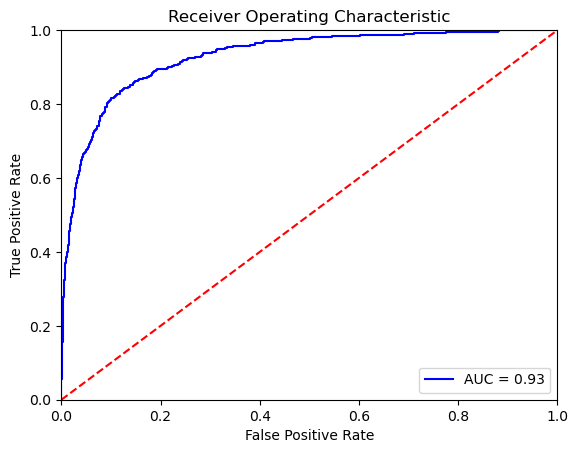

In [59]:
light_untuned_gl = train_lightgbm(X_train_gl, y_train_gl)
evaluate_model(light_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(light_untuned_gl, "LightGBM", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.88%
------------------------------------------------
Confusion Matrix:
      0    1
0  5618   69
1   241  126
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5687
           1       0.65      0.34      0.45       367

    accuracy                           0.95      6054
   macro avg       0.80      0.67      0.71      6054
weighted avg       0.94      0.95      0.94      6054



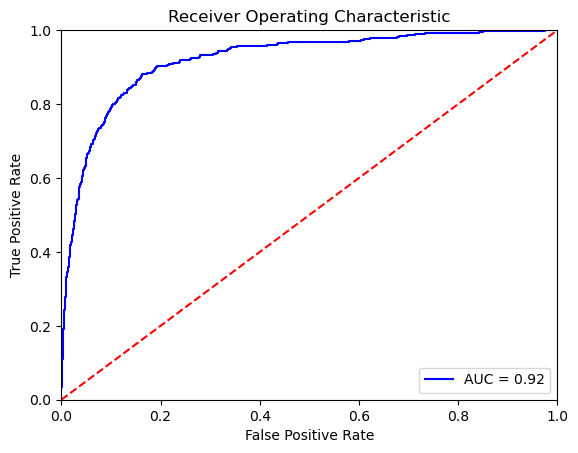

In [60]:
stack_untuned_gl = train_stacking_rf_svm(X_train_gl, y_train_gl)
evaluate_model(stack_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(stack_untuned_gl, "StackingClassifier-RF-SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl,
               y_test_gl)

In [61]:
svc_untuned_gl = train_svc(X_train_gl, y_train_gl)
add_to_eval_df(svc_untuned_gl, "SVC", "untuned", "glove200d", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

### Model Evaluation

In [62]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,tuning,vec_variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
22,StackingClassifier-RF-SVC,untuned,tf,0.999504,0.996885,0.995851,0.996367,0.960522,0.717687,0.574932,0.638427
23,SVC,untuned,tf,0.995044,0.996667,0.930498,0.962446,0.958209,0.735537,0.485014,0.584565
12,RandomForest,untuned,tf,1.000000,1.000000,1.000000,1.000000,0.959696,0.855491,0.403270,0.548148
17,XGBoost,gridsearch,tf,0.965944,0.943119,0.533195,0.681246,0.956227,0.757576,0.408719,0.530973
16,XGBoost,untuned,tf,0.963183,0.960581,0.480290,0.640387,0.956723,0.796610,0.384196,0.518382
21,LightGBM,untuned,tf,0.965803,0.947858,0.528008,0.678215,0.954410,0.726368,0.397820,0.514085
19,XGBoost,optuna,tf,0.959714,0.889546,0.467842,0.613188,0.954245,0.727273,0.392371,0.509735
28,XGBoost,untuned,glove,1.000000,1.000000,1.000000,1.000000,0.953089,0.698565,0.397820,0.506944
29,XGBoost,gridsearch,glove,1.000000,1.000000,1.000000,1.000000,0.955236,0.763736,0.378747,0.506375
33,LightGBM,untuned,glove,0.999292,1.000000,0.989627,0.994786,0.953915,0.726804,0.384196,0.502674


In [63]:
evaluation.to_csv("eval/evaluation_olddata_train-cleaned.csv")